Uses our NN framework to run a RNN, LSTM or GRU   
Splits train and test datasets in different ways  
Basic LogLinkFeedForward NN, RNN, LSTM and GRU  
Y variate is ultimate paid claim  
Error term is MSE, alternative error terms can be included  

Applies Tensorboard

In [8]:
cutoff = 40       # 40 is the (hard-coded) cut-off as set out previously
cutoff1=32
nn_iter = 2001     # 100 for experimentation, 500 appears to give models that have fully converged or are close to convergence. 


cv_runs = 24      # Testing only: 4, proper runs of the models: 24
glm_iter = 500    # 500 epochs for gradient descent fitting of GLMs
nn_cv_iter = 100  # Lower for CV to save running time
mdn_iter = 1000   # Appears to need 1000 to give models that have fully converged or are close to convergence. 

#Specify is development periods with no transactions to be filled in or not
#filename="data_origframework.csv"
#filename="data_origframework_nofills.csv"
filename="data_origframework_nofills_nosttl.csv"

#Labelling
from datetime import datetime
now=datetime.now()

In [3]:
pip install tensorboard


Looking in indexes: https://packagemanager/pypi/latest/simple, https://packagemanager/pyRSA/latest/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.0 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 349.5 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [tensorboard] [tensorboard]data-server]
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip show pandas numpy scikit-learn tensorboard

Name: pandas
Version: 2.2.0
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from torch.utils.data.sampler import BatchSampler, RandomSampler
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.autograd import Variable

from torch.nn.utils.rnn import pad_sequence

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
#, SplineTransformer
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_consistent_length

#from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
# from skopt import BayesSearchCV
import math

import torch  
from torch.utils.tensorboard import SummaryWriter  


In [4]:
pd.options.display.float_format = '{:,.2f}'.format

# Tensorboard

First make sure tensorboard is installed:  
$ pip install tensorboard

import torch  
from torch.utils.tensorboard import SummaryWriter  
writer = SummaryWriter()  

Writer will output to current directory by default.

To change output directory to ./runs/ directory:  
In terminal run these 3 commands:  
1. pwd [check what current directory is]   
2. cd /Users/sarahmacdonnell/documents/work/MLR_WP/NNCode/Diagnostics [change to current directory that you are running the notebook in]  
3. tensorboard --logdir=runs [run tensor board, creating new directory to store output of runs]   

Get message in terminal:  
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.2 at http://localhost:6006/ (Press CTRL+C to quit)

Copy link provided (here it was http://localhost:6006/) into browser



More info:  
https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html


# Data

In [5]:
#Read in dat and create new train/test splits
#dirname_in="https://raw.githubusercontent.com/MLRWP/mlrwp-book/main/Research/"
dirname="/home/nigel/git/MLR_working_party/01_data/"
#filename="data_origframework.csv"
#filename="data_origframework_nofills.csv"
filename="data_origframework_nofills_nosttl.csv"

dat = pd.read_csv(
    dirname + filename
)

### Set up train and test sets

use train_ind for rectangular data  
use train_ind_time for calendar period - cutoff is set at the start of this

In [6]:
dat

,Unnamed: 0.1,Unnamed: 0,claim_no,pmt_no,occurrence_period,occurrence_time,claim_size,notidel,setldel,payment_time,...,payment_delay,noti_period,settle_period,development_period,is_settled,payment_size_cumulative,log1_paid_cumulative,train_ind,train_ind_time,cv_ind
0,0,1,1,1,1,0.73,"232,310.09",0.66,23.21,5.33,...,3.93,2,25,5,False,"13,226.34",9.49,False,True,1
1,1,2,1,2,1,0.73,"232,310.09",0.66,23.21,10.09,...,4.76,2,25,10,False,"28,912.20",10.27,False,True,1
2,2,3,1,3,1,0.73,"232,310.09",0.66,23.21,18.02,...,7.93,2,25,18,False,"43,555.48",10.68,False,True,4
3,3,4,1,4,1,0.73,"232,310.09",0.66,23.21,22.82,...,4.79,2,25,22,False,"213,597.38",12.27,False,True,3
4,5,6,2,1,1,0.33,"237,675.12",0.74,22.15,3.46,...,2.38,2,24,3,False,"14,014.05",9.55,False,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257,19316,19317,3663,1,40,39.87,"40,653.72",2.29,10.67,44.56,...,2.40,43,53,5,False,"2,618.23",7.87,False,False,0
15258,19317,19318,3663,2,40,39.87,"40,653.72",2.29,10.67,46.40,...,1.84,43,53,7,False,"4,832.11",8.48,False,False,2
15259,19318,19319,3663,3,40,39.87,"40,653.72",2.29,10.67,48.45,...,2.06,43,53,9,False,"7,124.86",8.87,False,False,4
15260,19319,19320,3663,4,40,39.87,"40,653.72",2.29,10.67,50.24,...,1.78,43,53,11,False,"9,492.18",9.16,False,False,1


In [9]:
dat["train_ind_time"] = (dat.payment_period <= cutoff1)
dat["test_ind_time"] = (dat.payment_period <= cutoff)
dat["train_settled"] = (dat.settle_period <= cutoff)
dat["settled_flag"] = (dat.settle_period <= cutoff1)

dat['is_settled'] = dat['is_settled'].astype(int)
dat["is_settled_future"] = (dat.is_settled)
dat.loc[dat['payment_period'] > cutoff, 'is_settled_future'] = -1
dat["future_flag"]= ~dat["train_ind_time"]

dat["future_paid_cum"] = (dat.log1_paid_cumulative)
dat.loc[dat['payment_period'] > cutoff, 'future_paid_cum'] = 12.3

dat["L250k"]=0
dat.loc[dat['claim_size'] > 250000, 'L250k'] = 1

currentdev = dat[dat['payment_period'] == cutoff].set_index('claim_no')['development_period'].to_dict()
dat['curr_dev'] = dat['claim_no'].map(currentdev)
dat["curr_dev"].fillna(0, inplace=True)

currentpaid = dat[dat['payment_period'] == cutoff].set_index('claim_no')['log1_paid_cumulative'].to_dict()
dat['curr_paid'] = dat['claim_no'].map(currentpaid)
dat["curr_paid"].fillna(0, inplace=True)

currentpmtno = dat[dat['payment_period'] == cutoff].set_index('claim_no')['pmt_no'].to_dict()
dat['curr_pmtno'] = dat['claim_no'].map(currentpmtno)
dat["curr_pmtno"].fillna(0, inplace=True)

<positron-console-cell-9>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-9>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col

#### Define columns to keep  

In [10]:
# Features to include per transaction
features = [
    "occurrence_time", 
#    "initial_case_estimate",
    "notidel", 
    "development_period", 
    "pmt_no",
    "log1_paid_cumulative",
#    "settled_flag",
#    "is_settled",
#    "future_paid_cum",
#    "future_flag"
#    "train_ind_time" #past flag
#    "log1_incurred_cumulative",
#    "max_paid_dev_factor",
#    "min_paid_dev_factor",
#    "max_incurred_dev_factor",
#    "min_incurred_dev_factor",
]

data_cols=features + ["claim_no"]

youtput="claim_size"

#### Define train and test datasets  

In [11]:
#X_train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.is_settled == 1), list_of_features])
#y_train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.is_settled == 1), ["claim_size"]])

#Rectangular
#trainx = (dat.loc[(dat.train_ind == 1), features + ["claim_no"]])
#y_train = (
#    dat.loc[(dat.train_ind == 1)]
#    .groupby('claim_no')[youtput].last()
#)

#testx = (dat.loc[(dat.train_ind == 0), features + ["claim_no"]])
#y_test = (
#    dat.loc[dat.train_ind == 0]
#    .groupby('claim_no')[youtput].last()  
#)

#S3
trainx = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.train_settled == 1), features + ["claim_no"]])
y_train = (
    dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.train_settled == 1)]
    .groupby('claim_no')[youtput].last()
)

#train: include outstanding claims too
#trainx = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1), features + ["claim_no"]])
#y_train = (
#    dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1)]
#    .groupby('claim_no')[youtput].last()
#)

testx = (dat.loc[(dat.test_ind_time == 1) & (dat.train_ind == 0) & (dat.train_settled == 0),  features + ["claim_no"]])
y_test = (
    dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 0) & (dat.train_settled == 0)]
    .groupby('claim_no')[youtput].last()
)

#include settled claims too
#testx = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 0),  features + ["claim_no"]])
#y_test = (
#    dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 0) & (dat.train_settled == 0)]
#    .groupby('claim_no')[youtput].last()
#)

#S0
#X_train = (dat.loc[(dat.train_ind == 1) & (dat.train_settled == 1), list_of_features])
#y_train = (dat.loc[(dat.train_ind == 1) & (dat.train_settled == 1), ["claim_size"]])

#X_test = (dat.loc[(dat.train_ind == 0) & (dat.train_settled == 1), list_of_features])
#y_test = (dat.loc[(dat.train_ind == 0) & (dat.train_settled == 1), [youtput]])

#S6
#X_test = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 0), list_of_features])
#y_test = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 0), ["payment_size_cumulative"]])

#S5
#X_test = (dat.loc[(dat.train_ind == 0) & (dat.train_settled == 0), list_of_features])
#y_test = (dat.loc[(dat.train_ind == 0) & (dat.train_settled == 0), [youtput]])

#S4
#X_train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1), list_of_features])
#y_train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1), ["payment_size_cumulative"]])


#S2
#X_train = (dat.loc[(dat.train_ind_time == 1) & (dat.is_settled == 1), list_of_features])
#y_train = (dat.loc[(dat.train_ind_time == 1) & (dat.is_settled == 1), ["claim_size"]])

#X_test = (dat.loc[(dat.train_ind_time == 0) & (dat.is_settled == 0), list_of_features])
#y_test = (dat.loc[(dat.train_ind_time == 0) & (dat.is_settled == 0), ["claim_size"]])

#X = (dat.loc[:, list_of_features])
#y = (dat.loc[:, youtput])

#Output files used to compare train and test subsets in Tableau
#triangletrain = (X_train
#    .groupby(["occurrence_time", "development_period"], as_index=False)
#    .agg({"log1_paid_cumulative": "sum"})
#    .sort_values(by=["occurrence_time", "development_period"])
#)
#trainsum=triangletrain.pivot(index = "occurrence_time", columns = "development_period", values = "log1_paid_cumulative")

#trainsum.to_csv("/Users/sarahmacdonnell/Documents/Work/MLR_WP/Gregtraintri.csv")

dat.loc[:, features + [youtput, "claim_no"]]

,occurrence_time,notidel,development_period,pmt_no,log1_paid_cumulative,claim_size,claim_no
0,0.73,0.66,5,1,9.49,"232,310.09",1
1,0.73,0.66,10,2,10.27,"232,310.09",1
2,0.73,0.66,18,3,10.68,"232,310.09",1
3,0.73,0.66,22,4,12.27,"232,310.09",1
4,0.33,0.74,3,1,9.55,"237,675.12",2
...,...,...,...,...,...,...,...
15257,39.87,2.29,5,1,7.87,"40,653.72",3663
15258,39.87,2.29,7,2,8.48,"40,653.72",3663
15259,39.87,2.29,9,3,8.87,"40,653.72",3663
15260,39.87,2.29,11,4,9.16,"40,653.72",3663


In [12]:
nclms=trainx['claim_no'].nunique()
print(isinstance(trainx, pd.DataFrame), nclms)
nfeatures = len(features)
print(nfeatures)  

True 1298
5


#### Put in 3D tensor form ready for RNN  
This is all done in the pipeline using Make3D

In [13]:
writer = SummaryWriter()  

class TabularNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        module,
        criterion=nn.MSELoss(),
        max_iter=100,   
        max_lr=0.01,
        keep_best_model=False,
        batch_function=None,
        rebatch_every_iter=1,
        n_input=nfeatures,
        n_hidden=20,    
        n_output=1,
        l1_penalty=0.0,          # lambda is a reserved word
        l1_applies_params=["linear.weight", "hidden.weight"],
        weight_decay=0.0,
        batch_norm=False,
        interactions=False,
        dropout=0.0,
        clip_value=None,
        n_gaussians=3,
        verbose=1,                
        device="cpu", #if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),  # Use GPU if available, leave mps off until more stable
        init_bias=None,
        **kwargs
    ):
        """ Tabular Neural Network Regressor (for Claims Reserving)

        This trains a neural network with specified loss, Log Link and l1 LASSO penalties
        using Pytorch. It has early stopping.

        Args:
            module: pytorch nn.Module. Should have n_input and n_output as parameters and
                if l1_penalty, init_weight, or init_bias are used, a final layer 
                called "linear".

            criterion: pytorch loss function. Consider nn.PoissonNLLLoss for log link.

            max_iter (int): Maximum number of epochs before training stops. 
                Previously this used a high value for triangles since the record count is so small.
                For larger regression problems, a lower number of iterations may be sufficient.

            max_lr (float): Min / Max learning rate - we will use one_cycle_lr

            keep_best_model (bool): If true, keep and use the model weights with the best loss rather 
                than the final weights.

            batch_function (None or fn): If not None, used to get a batch from X and y

            rebatch_every_iter (int): redo batches every

            l1_penalty (float): l1 penalty factor. If not zero, is applied to 
                the layers in the Module with names matching l1_applies_params.

                (we use l1_penalty because lambda is a reserved word in Python 
                for anonymous functions)

            weight_decay (float): weight decay - analogous to l2 penalty factor
                Applied to all weights

            clip_value (None or float): clip gradient norms at a particular value
            
            n_hidden (int), batch_norm(bool), dropout (float), interactions(bool), n_gaussians(int): 
                Passed to module. Hidden layer size, batch normalisation, dropout percentages, and interactions flag.

            init_bias (coerces to torch.Tensor): set init_bias, passed to module. If none, default to np.log(y.mean()).values.astype(np.float32)

            verbose (int): 0 means don't print. 1 means do print.
        """
        self.module = module
        self.criterion = criterion
        self.keep_best_model = keep_best_model
        self.l1_penalty = l1_penalty
        self.l1_applies_params = l1_applies_params
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.batch_norm = batch_norm
        self.batch_function = batch_function
        self.rebatch_every_iter = rebatch_every_iter
        self.interactions = interactions
        self.dropout = dropout
        self.n_gaussians = n_gaussians
        self.device = device
        self.target_device = torch.device(device)    
        self.max_lr = max_lr
        self.init_bias = init_bias
        self.print_loss_every_iter = max(1, int(max_iter / 10))
        self.verbose = verbose
        self.clip_value = clip_value
        self.kwargs = kwargs

        
    def fix_array(self, y):
        "Need to be picky about array formats"
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y = y.astype(np.float32)
        return y
        

    def setup_module(self, n_input, n_output):
         
        # Training new model
        self.module_ = self.module(
            n_input=n_input, 
            n_output=n_output,
            n_hidden=self.n_hidden,
            batch_norm=self.batch_norm,
            dropout=self.dropout,
#            interactions=self.interactions,
#            n_gaussians=self.n_gaussians,
            init_bias=self.init_bias_calc if self.init_bias is None else self.init_bias,
            **self.kwargs
        ).to(self.target_device)
        

    def fit(self, X, y):
        # The main fit logic is in partial_fit
        # We will try a few times if numbers explode because NN's are finicky and we are doing CV
        n_input = X.shape[-1]
        n_output = 1 if y.ndim == 1 else y.shape[-1]
        self.init_bias_calc = np.log(y.mean()).astype(np.float32)
        self.setup_module(n_input=n_input, n_output=n_output)

        # Partial fit means you take an existing model and keep training 
        # so the logic is basically the same
        self.partial_fit(X, y)
        
        return self


    def partial_fit(self, X, y):
        # Check that X and y have correct shape
        check_consistent_length(X, y)

        # Convert to Pytorch Tensor
        X_tensor = X.to(self.target_device)
        y_tensor = torch.from_numpy(self.fix_array(y)).to(self.target_device)

        # Optimizer - the generically useful AdamW. Other options like SGD
        # are also possible.
        
#        optimizer = torch.optim.SGD(
#            params=self.module_.parameters(),
#            lr=0.000000000001,
#            weight_decay=self.weight_decay
#        )
        
        optimizer = torch.optim.AdamW(
            params=self.module_.parameters(),
            lr=self.max_lr / 10,
            weight_decay=self.weight_decay
        )
        
        # Scheduler - one cycle LR
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.max_lr, 
            steps_per_epoch=1, 
            epochs=self.max_iter
        )
        
        # Loss Function
        try:
            loss_fn = self.criterion(log_input=False).to(self.target_device)  # Pytorch loss function
        except TypeError:
            loss_fn = self.criterion  # Custom loss function

        best_loss = float('inf') # set to infinity initially

        if self.batch_function is not None:
            X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        else:
            X_tensor_batch, y_tensor_batch = X_tensor, y_tensor

        # Training loop
        for epoch in range(self.max_iter):   # Repeat max_iter times

            self.module_.train()
            y_pred = self.module_(X_tensor_batch)  #  Apply current model

#Tensorboard
            expected=y_pred.detach().numpy()
            ln_expected=np.log(expected)
            ln_actual=np.log(y_tensor_batch)
            diff=y_tensor_batch - expected
#            writer.add_figure('AvsE', plt.scatter(y_tensor_batch, expected), global_step=epoch)
#            writer.add_embedding(y_tensor_batch)
            
            loss = loss_fn(y_pred, y_tensor_batch) #  What is the loss on it?
# Error 1: ((E-A)/A)^2
#            loss = torch.mean(torch.square((y_pred - y_tensor_batch)/y_tensor_batch))
# Error 1.1: ((E-A)/A)^2)*1000000
#            loss = torch.mean(torch.square((y_pred - y_tensor_batch)/y_tensor_batch))*1000000
# Error 2: (A-E)^2/E
#            loss = torch.mean(torch.square((y_pred - y_tensor_batch))/y_pred)
# Error 3: ((A/E)-1)^2
#            loss = torch.mean(torch.square((y_pred / y_tensor_batch) - 1))
# Error 4: (ln(A/F))^2
#            loss = torch.mean(torch.square(torch.log(y_pred - y_tensor_batch)))

# ((E-A)/E)^2
#            loss = torch.mean(torch.square((y_pred - y_tensor_batch)/y_pred))

    
#Tensorboard
            writer.add_scalar("Loss", loss, epoch)
#            writer.add_scalar("BestLoss", best_loss, epoch)
#            print("BestLoss: ", best_loss, " Train Loss: ", loss.data.tolist(), " Epoch: ", epoch)

#Learning rate
            current_lr = scheduler.get_last_lr()[0]  # Assuming one parameter group
            writer.add_scalar('Learning Rate', current_lr, epoch)

# Weights and biases
            for name, param in self.module_.named_parameters():       
                writer.add_histogram(name, param, epoch)
                if param.grad is not None:
                    writer.add_histogram(f'{name}.grad', param.grad, epoch)
#                print(f"Name: {name}, Value: {param}, Gradient: {param.grad}")
                
            if self.l1_penalty > 0.0:        #  Lasso penalty
                loss += self.l1_penalty * sum(
                    [
                        w.abs().sum()
                        for p, w in self.module_.named_parameters()
                        if p in self.l1_applies_params
                    ]
                )
                
            if self.keep_best_model & (loss.item() < best_loss):
                best_loss = loss.item()
                self.best_model = self.module_.state_dict()

            optimizer.zero_grad()            #  Reset optimizer            
            loss.backward()                  #  Apply back propagation
            
            # gradient norm clipping
            if self.clip_value is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.module_.parameters(), self.clip_value)
                # check if gradients have been clipped
                if (self.verbose >= 1) & (grad_norm > self.clip_value):
                    print(f'Gradient norms have been clipped in epoch {epoch}, value before clipping: {grad_norm}')    

            optimizer.step()                 #  Update model parameters
            scheduler.step()

            if torch.isnan(loss.data).tolist():
                raise ValueError('Error: nan loss')


            # Every self.print_loss_every_iter steps, print RMSE 
            if (epoch % self.print_loss_every_iter == 0) and (self.verbose > 0):
                self.module_.eval()                     # Eval mode 
                self.module_.point_estimates=True       # Distributional models - set to point                
                y_pred_point = self.module_(X_tensor)   # Get "real" model estimates
                assert(y_pred_point.size() == y_tensor.size())
                rmse = torch.sqrt(torch.mean(torch.square(y_pred_point - y_tensor)))
                self.module_.train()                     # back to training
                self.module_.point_estimates=False       # Distributional models - set to point
                
                print("Train RMSE: ", rmse.data.tolist(), " Train Loss: ", loss.data.tolist(), " Epoch: ", epoch)
#                for name, param in self.module_.named_parameters():       
#                    print(name, param, epoch)


#Tensorboard
#                writer.add_scalar("Loss", loss, epoch)
                writer.add_scalar("RMSE", rmse, epoch)
                writer.add_histogram('Expected', expected, epoch)
                writer.add_histogram('Diff', diff, epoch)

                fig, ax = plt.subplots()
                ax.scatter(y_tensor_batch, expected)
                ax.set_xlabel('Actual', fontsize=15)
                ax.set_ylabel('Expected', fontsize=15)
                ax.set_title('A vs E')               
                writer.add_figure('AvsE', fig, epoch)

                fig, ax = plt.subplots()                
                ax.scatter(ln_actual, ln_expected)
                ax.plot([0,16],[0,16])
                ax.set_xlabel('Actual', fontsize=15)
                ax.set_ylabel('Expected', fontsize=15)
                ax.set_title('A vs E Logged')               
                writer.add_figure('AvsE Logged', fig, epoch)

#ax.grid(True)
#fig.tight_layout()                
                
            if (self.batch_function is not None) & (epoch % self.rebatch_every_iter == 0):
                print(f"refreshing batch on epoch {epoch}")
                X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        
            if (epoch==nn_iter-1):
                for name, param in self.module_.named_parameters():    
                    # Convert parameter tensor to numpy array and flatten it
                    param_np = param.detach().numpy().flatten()
                    fig, ax = plt.subplots()
                    ax.bar(range(len(param_np)), param_np)
#                    ax.set_title(f'Parameters/{name}')
                    ax.set_xlabel('Parameter Node')
                    ax.set_ylabel('Value')
                    writer.add_figure(f'Parameters/{name}', fig, epoch)
#                print(f"Name: {name}, Value: {param}, Gradient: {param.grad}")
#                        print(f"Name: {name}")
    

        if self.keep_best_model:
            self.module_.load_state_dict(self.best_model)
            self.module_.eval()
            
        return self


    def predict(self, X, point_estimates=True):
        # Checks
        check_is_fitted(self)      # Check is fit had been called
        check_consistent_length(X)

        # Convert to Pytorch Tensor
        X_tensor = X.to(self.target_device)
      
        self.module_.eval()  # Eval (prediction) mode
        self.module_.point_estimates = point_estimates

        # Apply current model and convert back to numpy
        if point_estimates:
            y_pred = self.module_(X_tensor).cpu().detach().numpy()
            if y_pred.shape[-1] == 1: 
                return y_pred.ravel()
            else:
                return y_pred
        else:
            y_pred = self.module_(X_tensor)
            return y_pred


    def score(self, X, y):
        # Negative RMSE score (higher needs to be better)
        y_pred = self.predict(X)
        y = self.fix_array(y)
        return -np.sqrt(np.mean((y_pred - y)**2))

    def get_hidden_state(self, X):
        check_is_fitted(self)
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        X_tensor = torch.tensor(X).to(self.target_device)

        self.module_.eval()
        with torch.no_grad():
            _, hn = self.module_(X_tensor, return_hn=True)

        return hn.cpu().numpy()
    
class ColumnKeeper(BaseEstimator, TransformerMixin):
    """Keeps named cols, preserves DataFrame output"""
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X.copy()[self.cols]


        
class Make3D(BaseEstimator, TransformerMixin):
    def __init__(self, data_cols):
        self.features = features

    def fit(self, X, y=None):
        # No fitting necessary; return self
        return self

    def transform(self, X):
        # Group by 'claim_no'
        grouped = X.groupby('claim_no')
        # Convert each group to a tensor
        X_tensors = [torch.tensor(group[self.features].values, dtype=torch.float32) for _, group in grouped]
        # Pad sequences to the same length
        X_padded = pad_sequence(X_tensors, batch_first=True)
        return X_padded
    

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', MinMaxScaler(), features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False  # Optional: keeps original names cleaner
    )

preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['occurrence_time', 'notidel',
                                  'development_period', 'pmt_no',
                                  'log1_paid_cumulative'])],
                  verbose_feature_names_out=False)

In [15]:
class BasicLogGRU(nn.Module):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        batch_norm,
        dropout,
        init_bias,
        **kwargs
    ):
        super(BasicLogGRU, self).__init__()

        self.n_hidden = n_hidden
        self.batch_norm_enabled = batch_norm
        
        self.gru = nn.GRU(n_input, n_hidden, batch_first=True)

        if self.batch_norm_enabled:
            self.bn = nn.BatchNorm1d(n_hidden)
            
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc = nn.Linear(n_hidden, n_output)

        if isinstance(init_bias, float) or isinstance(init_bias, int):
            self.fc.bias.data.fill_(init_bias)

    def forward(self, x):
        batch_size = x.size(0)

        # GRU only needs one hidden state (h0), no cell state
        h0 = torch.zeros(1, batch_size, self.n_hidden).to(x.device)

        out, _ = self.gru(x, h0)

        out = self.dropout(out[:, -1, :])  # Use the output from the last time step
        out = self.fc(out)

        return torch.exp(out)

In [16]:
class BasicLogLSTM(nn.Module):
    def __init__(
        self, 
        n_input, 
        n_hidden, 
        n_output,
        init_bias,
        batch_norm=False,
        dropout=0.0,
        **kwargs
    ):
        super(BasicLogLSTM, self).__init__()
        
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first=True)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        self.fc = nn.Linear(n_hidden, n_output)
#        self.init_bias = init_bias
        if isinstance(init_bias, float) or isinstance(init_bias, int):
            self.fc.bias.data.fill_(init_bias)

    def forward(self, x):
        batch_size = x.size(0)

        # h0 and c0 are the hidden and cell states
        h0 = torch.zeros(1, batch_size, self.n_hidden).to(x.device)
        c0 = torch.zeros(1, batch_size, self.n_hidden).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # LSTM returns (output, (hn, cn))

        out = self.dropout(out[:, -1, :])  # Use last time step's output
        out = self.fc(out)

        return torch.exp(out)

In [17]:
class BasicLogRNN(nn.Module):
    def __init__(
        self, 
        n_input, 
        n_hidden, 
        n_output,
        batch_norm,
        dropout,
        init_bias,
    ):
        super(BasicLogRNN, self).__init__()

        self.n_hidden = n_hidden
# the input data tensor has a shape of eg (batch size=100, 40, input_size=10), indicating 100 sequences/claims, 
#each of length 40, with 10 features per time step

        self.rnn = nn.RNN(n_input, n_hidden, batch_first=True) #The batch_first=True argument in nn.RNN indicates
#that the input tensors are in the shape of (batch_size, sequence_length, input_size

        self.fc = nn.Linear(n_hidden, n_output) #fully connected layer; mas to 20D hidden layer to a 1D output

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.n_hidden).to(x.device) #initialisation
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return torch.exp(out)

#n_input = 10 #number of features
#n_hidden = 20
#n_output = 1

In [18]:
class LogLinkForwardNet(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self, 
        n_hidden,                                          # hidden layer size
        batch_norm,                                        # whether to do batch norm (boolean) 
        dropout,                                           # dropout percentage,
        init_bias,                                     # init mean value to speed up convergence        
        n_input=8,                                         # number of inputs
        n_output=1,                                        # number of outputs
        
    ): 

        super(LogLinkForwardNet, self).__init__()

        self.hidden = torch.nn.Linear(n_input, n_hidden)   # Hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)  # New hidden layer
#        self.hidden3 = torch.nn.Linear(n_hidden, n_hidden)  # Third hidden layer
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchn = torch.nn.BatchNorm1d(n_hidden)   # Batchnorm layer
        self.dropout = nn.Dropout(dropout)

        self.linear = torch.nn.Linear(n_hidden, n_output)  # Linear coefficients

        nn.init.zeros_(self.linear.weight)                 # Initialise to zero
        # nn.init.constant_(self.linear.bias, init_bias)        
        self.linear.bias.data = torch.tensor(init_bias)

    # The forward function defines how you get y from X.
    def forward(self, x):
        
        # First hidden layer
        h = F.relu(self.hidden(x))
#Not using batchnorm here otherwise would need to update these
        if self.batch_norm:
            h = self.batchn(h)
        h = self.dropout(h)

        # New second hidden layer
        h2 = F.relu(self.hidden2(h))
        if self.batch_norm:
            h2 = self.batchn2(h2)
        h2 = self.dropout(h2)

        # Third hidden layer
#        h3 = F.relu(self.hidden3(h2))
#        if self.batch_norm:
#            h3 = self.batchn3(h3)
#        h3 = self.dropout(h3)

#1 Layer:            
        return torch.exp(self.linear(h2))                   # log(Y) = XB -> Y = exp(XB)        
                
#3 Layers:                
#        return torch.exp(self.linear(h2))                   # log(Y) = XB -> Y = exp(XB)

In [19]:
nfeatures

5

In [20]:
model_NN = Pipeline(
    steps=[
        ("keep", ColumnKeeper(data_cols)),   
        ('zero_to_one', preprocessor),       # Important! Standardize deep learning inputs.
        ('3Dtensor', Make3D(features)),
        ("model", TabularNetRegressor(BasicLogGRU, n_input=nfeatures, n_hidden=32, n_output=1, max_iter=nn_iter))
    ]
)

In [21]:
import time
# Start time
start_time = time.time()

model_NN.fit(
    trainx,
    y_train
)

# End time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

<positron-console-cell-21>:190: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
<positron-console-cell-21>:191: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train RMSE:  258025.578125  Train Loss:  66577203200.0  Epoch:  0
Train RMSE:  212809.28125  Train Loss:  45331210240.0  Epoch:  200
Train RMSE:  99391.953125  Train Loss:  8648037376.0  Epoch:  400
Train RMSE:  86124.8671875  Train Loss:  7422403584.0  Epoch:  600
Train RMSE:  81572.375  Train Loss:  6932165120.0  Epoch:  800
Train RMSE:  74281.5859375  Train Loss:  5521842176.0  Epoch:  1000
Train RMSE:  67244.96875  Train Loss:  4528493056.0  Epoch:  1200
Train RMSE:  58266.9453125  Train Loss:  3398225152.0  Epoch:  1400
Train RMSE:  56236.71484375  Train Loss:  3163651840.0  Epoch:  1600
Train RMSE:  55106.69921875  Train Loss:  3037008896.0  Epoch:  1800
Train RMSE:  54946.0  Train Loss:  3019062272.0  Epoch:  2000
Execution time: 177.262741 seconds


### Output graphs and measures to Tensorboard

#### Train dataset

In [22]:
youtput="claim_size"

train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.train_settled == 1)])

y_pred=model_NN.predict(train)

#merge y_pred back into dat for each claim
claim_nos = train["claim_no"].drop_duplicates()
pred_df = pd.DataFrame({
    "claim_no": claim_nos.values,
    "pred_claims": y_pred
})

if "pred_claims" in train.columns:
    train = train.drop(columns=["pred_claims"])

train_pred = train.merge(pred_df, on="claim_no", how="left")

train_pred["log_pred_claims"]=train_pred["pred_claims"].apply(lambda x: np.log(x+1))
train_pred["log_actual"]=train_pred[youtput].apply(lambda x: np.log(x+1))

train_pred["rpt_delay"]=np.ceil(train_pred.notidel).astype(int)

train_pred["diff"]=train_pred[youtput]-train_pred["pred_claims"]
train_pred["diffp"]=(train_pred[youtput]-train_pred["pred_claims"])/train_pred[youtput]

train_pred["pred_claims_decile"] = pd.qcut(train_pred["pred_claims"], 10, labels=False, duplicates='drop')
train_pred["pred_claims_20cile"] = pd.qcut(train_pred["pred_claims"], 20, labels=False, duplicates='drop')
train_pred["log_pred_claims_decile"] = pd.qcut(train_pred["log_pred_claims"], 10, labels=False, duplicates='drop')
train_pred["log_pred_claims_20cile"] = pd.qcut(train_pred["log_pred_claims"], 20, labels=False, duplicates='drop')

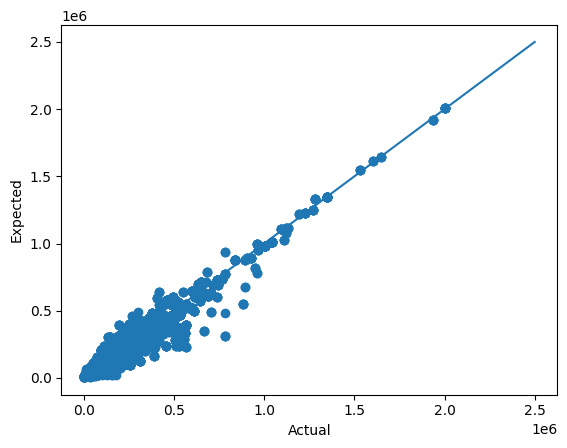

In [23]:
#AvsE all

plt.scatter(train_pred[youtput], train_pred["pred_claims"])
plt.xlabel('Actual')
plt.ylabel('Expected')
#plt.xlim([500000,550000])
#plt.ylim([0,1000000])
plt.plot([0,2500000],[0,2500000])

fig, ax = plt.subplots()
ax.scatter(train_pred[youtput], train_pred["pred_claims"])
ax.plot([0,3000000],[0,3000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Train AvsE all history')               
writer.add_figure('AvsE all Train', fig)

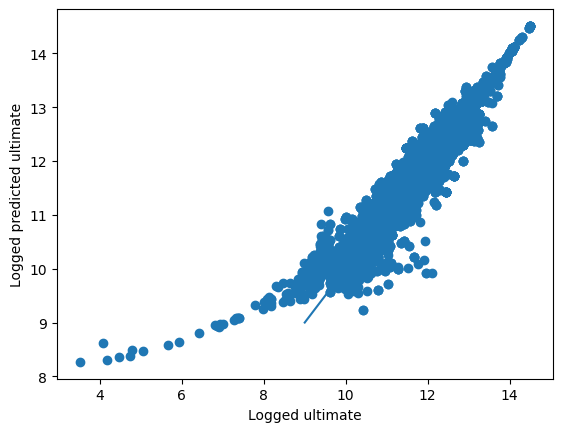

In [24]:
#Logged AvsE all
plt.plot([9,14],[9,14])
plt.scatter(train_pred["log_actual"], train_pred["log_pred_claims"])
#plt.xlim([6,8])
plt.xlabel('Logged ultimate')
plt.ylabel('Logged predicted ultimate')

fig, ax = plt.subplots()
ax.scatter(train_pred["log_actual"], train_pred["log_pred_claims"])
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Train AvsE All History')               
writer.add_figure('AvsE Logged All Train', fig)

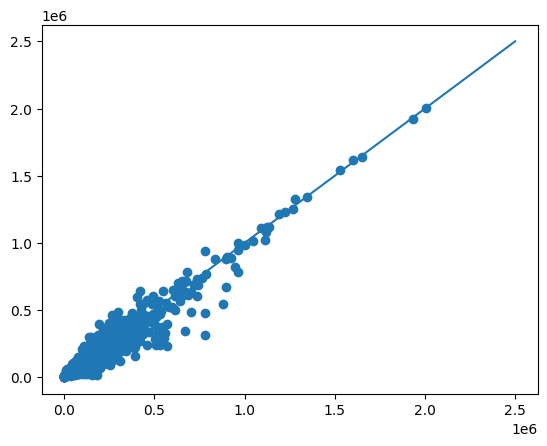

In [25]:
# AvsE Ult
dat_byclaim=train_pred.groupby("claim_no").last()
plt.scatter(dat_byclaim["claim_size"], dat_byclaim["pred_claims"])
plt.plot([0,2500000],[0,2500000])

fig, ax = plt.subplots()
ax.scatter(dat_byclaim["claim_size"], dat_byclaim["pred_claims"])
ax.plot([0,3000000],[0,3000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Train AvsE Ult only')               
writer.add_figure('AvsE Ult only Train', fig)

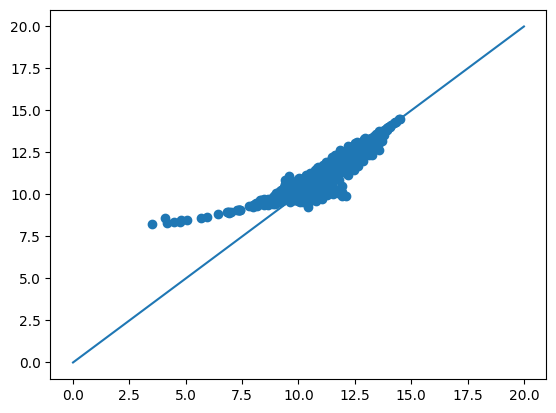

In [26]:
#Logged AvsE Ult
plt.plot([0,20],[0,20])
plt.scatter(dat_byclaim["log_actual"], dat_byclaim["log_pred_claims"])

fig, ax = plt.subplots()
ax.scatter(dat_byclaim["log_actual"], dat_byclaim["log_pred_claims"])
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Train AvsE Ult only')               
writer.add_figure('AvsE Ult only Logged Train', fig)

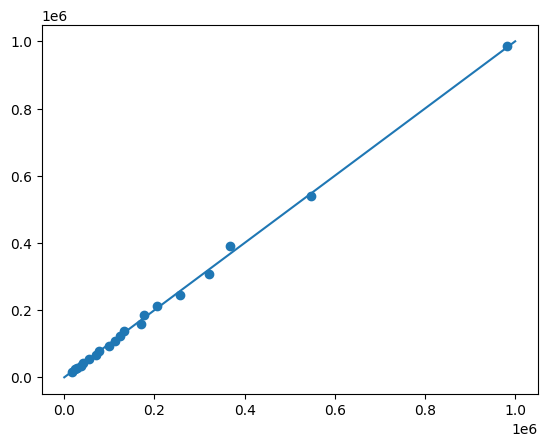

In [27]:
# QQ plot
X_sum = train_pred.groupby("pred_claims_20cile").agg("mean").reset_index()

plt.scatter(X_sum.claim_size, X_sum.pred_claims)
plt.plot([0,1000000],[0,1000000])

fig, ax = plt.subplots()
ax.scatter(X_sum.claim_size, X_sum.pred_claims)
ax.plot([0,1000000],[0,1000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title(' Train QQ plot 20')               
writer.add_figure('QQ plot Train', fig)

fig, ax = plt.subplots()
ax.scatter(X_sum.log_actual, X_sum.log_pred_claims)
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Train QQ plot 20')               
writer.add_figure('QQ plot Logged Train ', fig)

#### Test dataset

In [28]:
test = (dat.loc[(dat.test_ind_time == 1) & (dat.train_ind == 0) & (dat.train_settled == 0)])

youtput="claim_size"
y_pred=model_NN.predict(test)

#merge y_pred back into dat for each claim
claim_nos = test["claim_no"].drop_duplicates()
pred_df = pd.DataFrame({
    "claim_no": claim_nos.values,
    "pred_claims": y_pred
})

if "pred_claims" in test.columns:
    dat = dat.drop(columns=["pred_claims"])

test_pred = test.merge(pred_df, on="claim_no", how="left")

test_pred["log_pred_claims"]=test_pred["pred_claims"].apply(lambda x: np.log(x+1))
test_pred["log_actual"]=test_pred[youtput].apply(lambda x: np.log(x+1))

test_pred["rpt_delay"]=np.ceil(train_pred.notidel).astype(int)

test_pred["diff"]=test_pred[youtput]-train_pred["pred_claims"]
test_pred["diffp"]=(test_pred[youtput]-test_pred["pred_claims"])/test_pred[youtput]

test_pred["pred_claims_decile"] = pd.qcut(test_pred["pred_claims"], 10, labels=False, duplicates='drop')
test_pred["pred_claims_20cile"] = pd.qcut(test_pred["pred_claims"], 20, labels=False, duplicates='drop')
test_pred["log_pred_claims_decile"] = pd.qcut(test_pred["log_pred_claims"], 10, labels=False, duplicates='drop')
test_pred["log_pred_claims_20cile"] = pd.qcut(test_pred["log_pred_claims"], 20, labels=False, duplicates='drop')

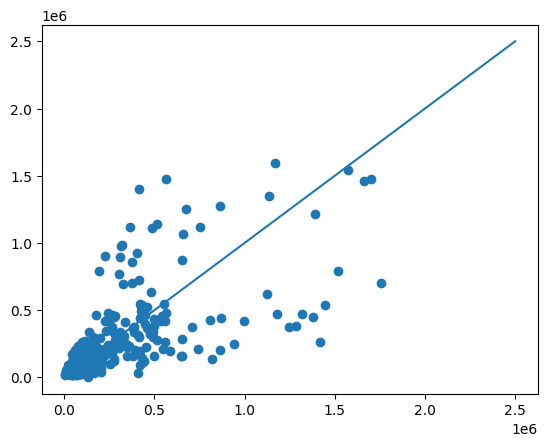

In [29]:
# AvsE All
fig, ax = plt.subplots()
ax.scatter(test_pred[youtput], test_pred["pred_claims"])
ax.plot([0,3000000],[0,3000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Test AvsE all history')               
writer.add_figure('AvsE all Test', fig)

fig, ax = plt.subplots()
ax.scatter(test_pred["log_actual"], test_pred["log_pred_claims"])
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Test AvsE All History')               
writer.add_figure('AvsE Logged All Test', fig)

#AvsE Ult
dat_byclaim=test_pred.groupby("claim_no").last()

fig, ax = plt.subplots()
ax.scatter(dat_byclaim[youtput], dat_byclaim["pred_claims"])
ax.plot([0,3000000],[0,3000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Test AvsE Ult only')               
writer.add_figure('AvsE Ult only Test', fig)

plt.scatter(dat_byclaim[youtput], dat_byclaim["pred_claims"])
plt.plot([0,2500000],[0,2500000])

fig, ax = plt.subplots()
ax.scatter(dat_byclaim["log_actual"], dat_byclaim["log_pred_claims"])
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Test AvsE Ult only')               
writer.add_figure('AvsE Logged Ult only Test', fig)

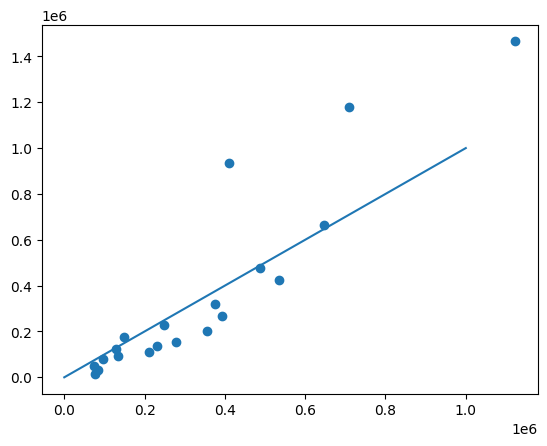

In [30]:
# QQ plot
X_sum = test_pred.groupby("pred_claims_20cile").agg("mean").reset_index()

plt.scatter(X_sum.claim_size, X_sum.pred_claims)
plt.plot([0,1000000],[0,1000000])

fig, ax = plt.subplots()
ax.scatter(X_sum.claim_size, X_sum.pred_claims)
ax.plot([0,1000000],[0,1000000])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title(' Test QQ plot 20')               
writer.add_figure(' QQ plot Test', fig)

fig, ax = plt.subplots()
ax.scatter(X_sum.log_actual, X_sum.log_pred_claims)
ax.plot([0,20],[0,20])
ax.set_xlabel('Actual', fontsize=15)
ax.set_ylabel('Expected', fontsize=15)
ax.set_title('Logged Test QQ plot 20')               
writer.add_figure('QQ plot Logged Test', fig)

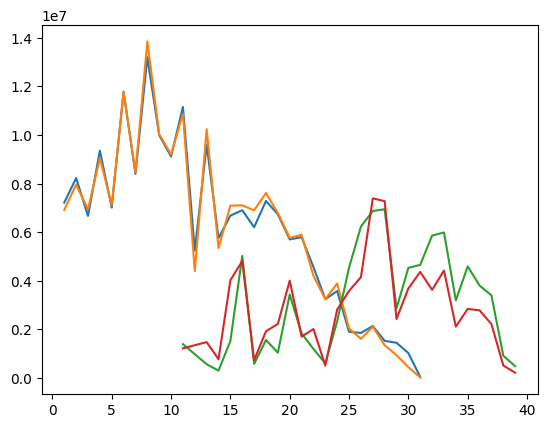

In [31]:
datTrainUlt=train_pred.groupby("claim_no").last()
datTestUlt=test_pred.groupby("claim_no").last()

datTrain_occ = datTrainUlt.groupby("occurrence_period").agg({youtput: "sum", "pred_claims": "sum"})
datTest_occ = datTestUlt.groupby("occurrence_period").agg({youtput: "sum", "pred_claims": "sum"})

plt.figure()

plt.plot(datTrain_occ.index, datTrain_occ[youtput])
plt.plot(datTrain_occ.index, datTrain_occ.pred_claims)

plt.plot(datTest_occ.index, datTest_occ[youtput])
plt.plot(datTest_occ.index, datTest_occ.pred_claims)

#plt.yscale("log") 

fig, ax = plt.subplots()
ax.plot(datTrain_occ.index, datTrain_occ[youtput], linestyle='--', label='Train Actual')
ax.plot(datTrain_occ.index, datTrain_occ.pred_claims, linestyle='--', label='Train Expected')
ax.plot(datTest_occ.index, datTest_occ[youtput], label='Test Actual')
ax.plot(datTest_occ.index, datTest_occ.pred_claims, label='Test Expected')
ax.set_yscale("log") 
#ax.plot([0,1000000],[0,1000000])
ax.set_xlabel('Occurrence period', fontsize=15)
ax.set_ylabel('Total Ultimate claims', fontsize=15)
ax.set_title('by Occurrence Period')     
ax.legend()
writer.add_figure('by Occur Period', fig)

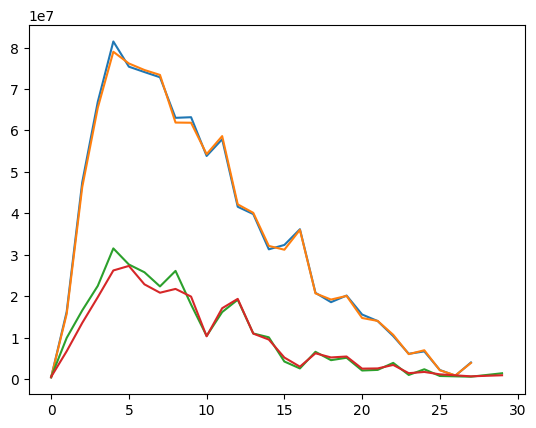

In [36]:
datTrain_dev = train_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})
datTest_dev = test_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})

plt.figure()

plt.plot(datTrain_dev.index, datTrain_dev[youtput])
plt.plot(datTrain_dev.index, datTrain_dev.pred_claims)

plt.plot(datTest_dev.index, datTest_dev[youtput])
plt.plot(datTest_dev.index, datTest_dev.pred_claims)

#plt.yscale("log") 

fig, ax = plt.subplots()
ax.plot(datTrain_dev.index, datTrain_dev[youtput], linestyle='--', label='Train Actual')
ax.plot(datTrain_dev.index, datTrain_dev.pred_claims, linestyle='--', label='Train Expected')
ax.plot(datTest_dev.index, datTest_dev[youtput], label='Test Actual')
ax.plot(datTest_dev.index, datTest_dev.pred_claims, label='Test Expected')
#ax.set_yscale("log") 
#ax.plot([0,1000000],[0,1000000])
ax.set_xlabel('Development period', fontsize=15)
ax.set_ylabel('Total claims', fontsize=15)
ax.set_title('by Devevelopment Period')     
ax.legend()
writer.add_figure('by Dev Period', fig)

### Output internal measures, eg layer weights, biases and gradients

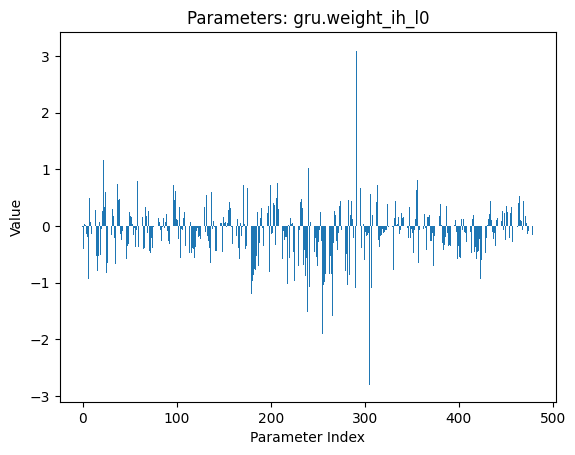

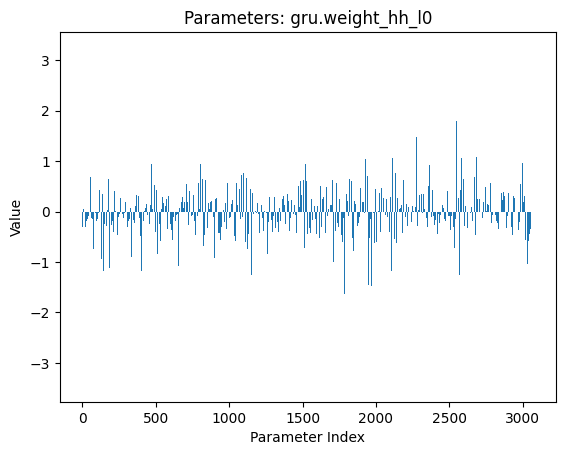

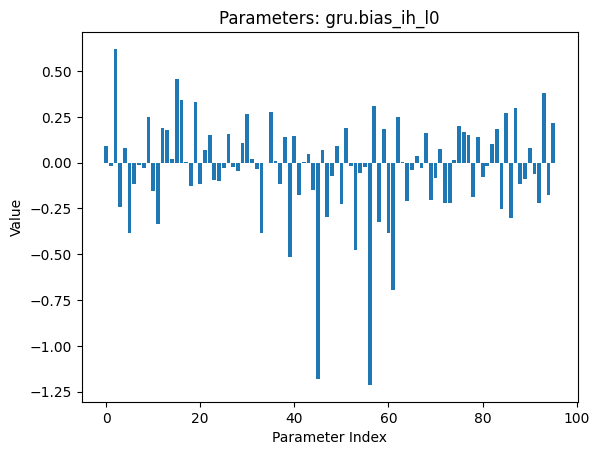

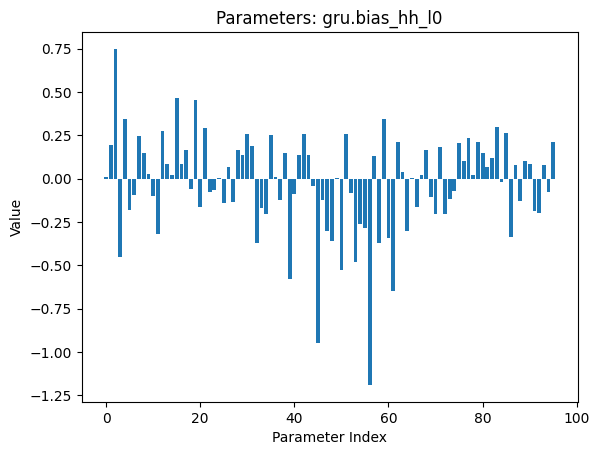

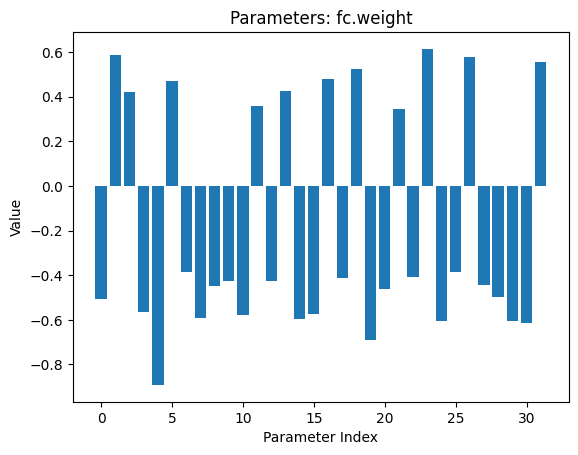

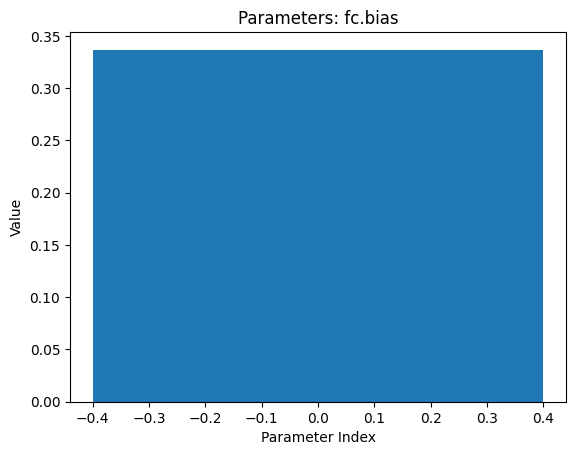

In [32]:
keep_params = {}

fitted_model = model_NN.named_steps['model'].module_

for name, param in fitted_model.named_parameters():
    # Convert parameter tensor to numpy array and flatten it
    param_np = param.detach().numpy().flatten()

    # Create a DataFrame for the parameter
    keep_params[name] = pd.DataFrame(param_np, columns=[name])

for name, df in keep_params.items():
    # Flatten the DataFrame to a 1D array for easy plotting
    params = df.values.flatten()
    plt.bar(range(len(params)), params)
    plt.title(f'Parameters: {name}')
    plt.xlabel('Parameter Index')
    plt.ylabel('Value')
    plt.show()
    

In [33]:
for name, param in fitted_model.named_parameters():
    print(keep_params[name])
#print(keep_params['hidden.weight'])

     gru.weight_ih_l0
0               -0.02
1               -0.40
2                0.03
3                0.01
4               -0.15
..                ...
475              0.17
476              0.23
477              0.35
478              0.17
479             -0.16

[480 rows x 1 columns]
      gru.weight_hh_l0
0                -0.23
1                -0.31
2                -0.16
3                -0.42
4                -0.36
...                ...
3067              0.18
3068             -0.75
3069             -0.25
3070             -0.16
3071              0.48

[3072 rows x 1 columns]
    gru.bias_ih_l0
0             0.09
1            -0.02
2             0.62
3            -0.24
4             0.08
..             ...
91           -0.06
92           -0.22
93            0.38
94           -0.17
95            0.22

[96 rows x 1 columns]
    gru.bias_hh_l0
0             0.01
1             0.19
2             0.75
3            -0.45
4             0.34
..             ...
91           -0.19
92      

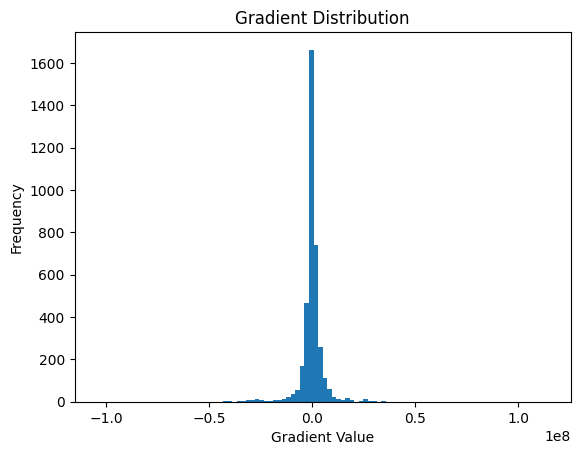

In [34]:
gradients = []

for param in fitted_model.parameters():
    if param.grad is not None:
        gradients.append(param.grad.view(-1).cpu().numpy())

plt.hist(np.concatenate(gradients), bins=100)
plt.title("Gradient Distribution")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.show()